# , Assignment: Transient Groundwater Flow Course IHE feb 2024

By prof. dr.ir. TN Olsthoorn

The [course material](https://github.com/Olsthoorn) can be found on Github

And as an [online course](https://readthedocs.org/profiles/Olsthoorn/) on readthedocs.org

The up-to-date s[yllabus as a pdf](https://github.com/Olsthoorn/TransientGroundwaterFlow) an also be found on Github.

On the same site you can find the PowerPoint presentations that are used in class and numerous exercises done in jupyter notebooks as well as the notebooks that generated the animations and all the pictures in the syllabus.

Old exams with and without answers and the asignments given over the years from 2006 can be find at the end of the [online course](https://readthedocs.org/profiles/Olsthoorn/) on Readthedocs. 

Extra material will be given to the students in class or save on github.

This year there will not be a written exam; only an assigment. This gives more oppertunities to learn and demonstrate the use of the transient analytic solutions presented in the course in a more data science scope. Nowadays, the anlytic formulas are at least as important as in the past before wide-spread computing being available, as more than ever we need them als tools to verify the many numeric models around, which just produce numbers, no insight. There outcomes require verification. Also before starting a new large groundwater model, most and valuable analysis can be and should be done ahead of it, to analyse the problem at hand and it's likely behavior to help us build better models by knowing what matters and by understanding and interpreting its outcomes. Moreover anaytic solutions allow us to generalize other outcomes and allow us to predict which are crucial paramters how variaion of the parameters will affect the outcomes. In short analytic solutions provide insight and guide is all the time when dealing with groundwater problems in a quantitive and qualitative way.

With more data science focus, we talk about analyzing field data using our analytic soltion, to find out how these field data can be interpreted and what the underlying parameters and relations are that cause the observed behavior. This way the filed data, mostly in terms of continuous or high-frequency registrations of water pressures, flows, recharge, evoration, pumping, water level fluctuations and so on, have to be analyzed. Signals have to be separated from noise, further, signals caused by different phenomena, all affecting the registered water pressure, have to be separated to determine what part of the observed behevior is due to what phenomenon, i.e. due to rain, pumping, water fluctuation and so on. These phenomena and their effects are all dynamic, and, therefore, we will mostly deal with large time series, which is what is called data-science.

In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erfc, k0 as K0, exp1
from scipy.integrate import quad
from scipy.signal import lfilter


# 1. Show the combined impact of a number of well

A water company extracts water from a dune are along the North sea and uses rows of wells to capture the water. The coordinates in Latitude (North), Longitude (East) are given [here](./data/PumpingSitesLybia.csv).

![Image projected on Google Earth](./images/LybiaPumpingSites.png)


## Let's get the coordinates first:

In [25]:
psites = pd.read_csv(os.path.join('./data', 'PumpingSitesLybia.csv'), index_col=0)

def wgs2km(phi, lam):
    """Return approximate x [km], y [km] from latitude [deg], longitude [deg]."""
    R = 6378.0 # km
    phi, lam = phi * np.pi / 180., lam * np.pi / 180.
    y = R * phi
    x = R * np.cos(phi) * lam
    return np.round(x, 1), np.round(y, 1)

xkm, ykm = wgs2km(psites['N_GWS84'].values, psites['E_GWS84'].values)

psites['xkm'] = xkm
psites['ykm'] = ykm

xBorderEgypt, yMediterranean = wgs2km(31, 25)
print('The x-coordinate of the Egyption border (Lon = 25deg) = {} km'.format(xBorderEgypt))
print('The y-coordinage of the Mediterranean   (Lat = 31deg) = {} km'.format(yMediterranean))

# Egyptian border point:
xB, yB = wgs2km(25, 25) 
print("Egyptian border point = (x={}, y={})".format(xB, yB))
psites

The x-coordinate of the Egyption border (Lon = 25deg) = 2385.4 km
The y-coordinage of the Mediterranean   (Lat = 31deg) = 3450.8 km
Egyptian border point = (x=2522.2, y=2782.9)


,E_GWS84,N_GWS84,xkm,ykm
Name,,,,
Ghadarnes,10.870178,29.330456,1054.9,3265.0
Jabal_Hasouna_NE,13.026915,27.042600,1291.6,3010.3
Jabal_Hasouna_E,14.782520,26.308762,1475.1,2928.6
Tazerbo_W,20.547701,24.853721,2075.5,2766.6
Tazerbo_E,22.248636,23.778889,2266.4,2647.0
Sarir,20.428217,27.471861,2017.6,3058.1
Jahgboub,23.895349,29.554800,2313.9,3290.0


Notices that these coordinates are in km (with respect to the equator and the zero meridian).

Now take the pumping capacity given that the transport pipes have $D = 4$ m diameter serving 2 pumping sites. Just assume a flow velocity of $v = 0.5$ m/s on average. The the discharge per pumping sites is estimated to

$$ Q \approx \frac{1}{2} \pi \, D^2 \, v $$

Per pump site

Further assume the transmissity of the Nubian Sandstone is $kD = 1000$ m2/d and $S = 0.2$.

Finally take the Mediterranean sea as a fixed-head boundary, giving rise to mirror wells.

## Questions

#### 1. Compute the drawdown today (assuming that the system has been working since 1984)

Compute the drawdown for 2024

#### 2. Compute the drawdown over time at the Egypian border at (x=2522.2, y=2782.9)

#### 3. Compute the drawdown over time (1984-2024) at 1000 m from the point Tazerbo assuming this is the approximate radius of the pumping well ensemble.

#### 4. Have a look on Google Earth, zoom in at point (lat=24.2 deg, lon=23.4 deg) to see the well site of Kufra

## Tide in groundwater

You are given the time series of two observation wells (piezomters) in the Amsterdam Water Supply Dunes (near Zandvoort) and the tide as it fluctuates in front of dunes along the coast in the North Sea. The distance from the beach is also given for the piezometers. From the two piezometers figure out how must damping of the amplitude and how much delay one has relative to the other. Also figure out the damping and delay with respect to the tide in th North Sea. Given the damping determined from the two piezometers determine how far from the coast the effective contact between the aquifer and the sea is. That is, at what distance from the coast is the fluctuation in the groundwater the same as that in the North Sea.

In [17]:
R = 6378.
10 * np.pi / 180 * R

1113.1709969219833

This assignment is built around several phenomena, as to use the different solutions explained in class and in the syllabus.

1. Analyze tide in groundwater

1. Analyze the effect of a given rise over time rise at the contact between surface water and the subsurface.

1. Analyze the drainage characteristics of a groundwater basin.

1. Analyze a pumping experiment that's just a bit more involved than just Theis or Hantush

## Impact of long term water level rise on the neighboring groudnwater

In the second half of the 20th century Lake Nasser in Egypt was created and filled with Nile Water. The rise of the water level over time will be given as a time series. It's you job to estimate to what distance and how much the groundwater adjacent to the Nasser Lake will be affected by 2030. For this assume the aquifer adjacent to the lake has constant transmissivity of 500 m2/d and constant storage coefficient of 10%.

## Drainage characteristics of a groundwater basin

You get a time series of the head measured in a groundwater basin of a given width. It becomes clear form observing the time series, that in very long dry periods, the head declines exponentially over time. You also know the elevation of the water level at either side of the basin. Estimate the transmissiviy of the basin when its width and its specific yield are given. With these parameters and the given recharge, simulate the dynamic behavior of the groundwater at your observation well to verify whether your data are correct.

## Analyze a pumping experiment that is not exactly according to Theis or to Hantush

During a pumping test in a well the head, and therefore, the drawdown, is measured in a whole series of observation wells. By showing the drawdowns as a function of the logarithm of time since the start of the pumping, a good insight in the reaction of the groundwater due to the pumping. It becomes obvious that the behavior is neither completely according to Theis, nor completely according to Hantush. But we can still analyze it whith the solutions that Theis and Hantush have given us. Analyze the pumping test, given the aquifer (and aquitard) characteristics and explain what is happening here, and therefore, why pumping tests should not be too short, especially what circumstances can make the answer tricky if the pumping test is too short.

### Tide in groundwater data

1. Tide at sea
2. Tide in observation well 1 (with position of well)
3. Tide in observation well 2 (with position of well)

All over a limited time

# 1. Impact of long-level rise of Lake Nasser (Egypt) on adjacent groundwater

Lake Nasser (Egypt) was formed after construction of the Assuan Dam in the early 20th century. The high dam was ready in 1965, after which Lake Nasser started to rise and extend until what it is today. The rise of the Lake between 1965 and 2005 is shown in the graph. The data with the water level over time is also given.
The rise of the lake level causes infiltration of Lake / Nile water into the aquifers adjacent to the lake. The groundwater in these aquifer will continue to rise over centuries while these aquiers slowly fill up. Full equilibirium will likely never be reached because there are not fixed head boundaries that could cause equilibrium to establish. But then the question raises, how far and to what exent does the groundwater rise? Will low areas get wet and form salt lakes? Can the new groundwater be used for agriculture and when and to what exent, and so on. To answer such questions you are asked to quantify the gradual rise of the grounwater in points at different distances from the lake lying in a cross section.

But to be able to quantify the effect and predict the future of it, you well need to calibrate you parameters kD and S. You can do that by matching your model with observations. Observed heads are available at 6 piezometers situated at different distances from the lake. For each piezometer the head is available for a number of times. You can do the calibration by hand, by changing the kD and the S and run the simulation again until your model matches the data. It is believed from the data obtained from drilling of the piezometers when they were intstalled, that the transmissivity will be in the order of 600 m2/d and the storage coefficient in the order of 5%. So these values are a good starting point for your calibration.

## Show the lake level and the measured heads

1. Show the lake level and the measured heads as a funciton of time in graphs in a single plot. For this you need to read the data into your notebook and plot them.

## Construct and test your model

Your model will be the analytic solution that gives the change of head $s(x, t)$ over time caused by a sudden change of head $A$ [m] at $x=0$. That is:
$$ S = A \, \mbox{erfc}(u),\,\,\,\,\,with\,\,\,\,\,u=\sqrt{\frac{x^2 S_y}{4 kD t}} $$

Use `convolution` (i.e. moving average weighted by the response) to simulate the head $h$ at the locations $x$ for which you were given the piezometer data. Show the results in the same plot together with the lake level and the measurements.

Note that the `Step Response` $SR$ is the effect of a sudden change at $x=0$ by $A = 1$ m!
Further realize that the change of head from one day to the next is a sudden change on that day.

The model is imply the convolution (moving average) that ais done by the function `scipy.signal.lfilter(SR, 1, np.diff(hLake))` where `np.diff(hLake)` is an array of the day-to-day changes of the lake level. `np.diff` just computes `hlake[i+1] - hlake[i]` or compactor without neding a loop, `hlake[1:] - hlake[:-1]`.

Show that your model works.

## Calibrate your model

When the model works, make sure that each run shows the results in a graph immediately. Then after running observe the differences between your model and the measurements.

Adapt the kD and or the S used for the run and run again, until the match between your model and the measurements satisfies you.

Then report the kD and S for which this is the case because these are were the caibration was aiming for.

Show the final results in a graph, together with the lake level.

## Compute the infiltration from the lake caused by the rise of its level

You are also asked to report on the total volume of water that has infiltrated over time as a consequence of the rise of the lake level.

This can also be computed by convolution. You only need to know the step response and then use the same input. The step response is of course, the infiltration flow caused by a sudeden unit change `A = 1` m at `x = 0`. This flow at x=0 can be easily derived form the formula for the head (using Darcy) but it can also be found in the Syllabus
$$ Q(0, t) = A \sqrt{\frac{kD S}{\pi t}}$$
and, therefore
$$ SR_Q = Q(0, t)\,\,\,\,for\,\,\,\ A=1\,\,\,\, \rightarrow \,\,\,\, SR_Q = \sqrt{\frac{kD S}{\pi t}} $$

Once you can simulate this inflow using convolution, you can also integrate it over the total period of your simulation, simply by adding the daily values. So how much it this, and what is its dimension?

Show these inflow over time in a graph below the previous one for comparison. Is there anything special to remark with respect to the results? If you think so, say so.

## Ddrainage characteristics of a groudnwater basin

1. The time series of the head at some location in the groudnwater basin.
2. The time series of the net recharge.

Bij Hand estimate the characteristic drainage time from the head decline in a long dry period.

With these characteristics simulate the head given the recharge time series using convolutionm.

In [84]:
os.path.isfile('PE-00-08.csv')
weather = pd.read_csv('PE-00-08.csv', header=0, index_col=0, parse_dates=True, dayfirst=True)
weather *= 0.001 # m/d

date
2000-01-01    0.000900
2000-01-02   -0.000095
2000-01-03    0.004500
2000-01-04    0.010900
2000-01-05   -0.000400
                ...   
2008-12-27   -0.000400
2008-12-28   -0.000400
2008-12-29   -0.000300
2008-12-30   -0.000400
2008-12-31   -0.000195
Length: 3288, dtype: float64

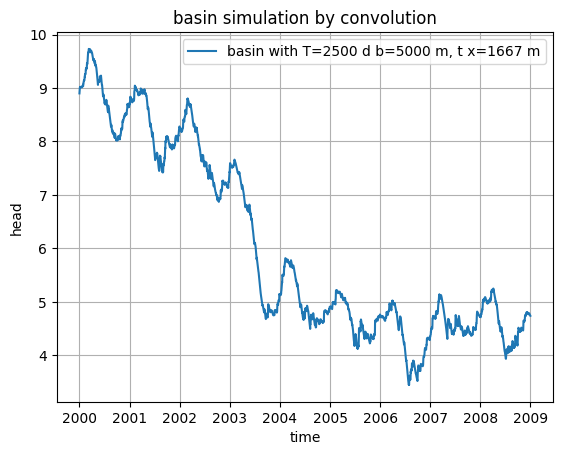

In [120]:
def hbasin_bock_response(b=None, x=None, tstep=None, kD=None, S=None, jmax=25):
    """Return the block response for the head at position x in the basin of half width b.

    This can be computed for all times (tau's at once).
    A is always 1, so not included in this function.

    Parameters
    ----------
    b: float
        half width of basin
    n: int
        number of points from -b to b
    tstep: float
        time step in block response
    kD: float
        Transmissivity
    S: float
        Storage coefficient of basin
    jmax: int
        number of terms in summation
    """
    T = b * b * S / kD
    taumax = 10 * T
    tau = np.arange(0, taumax, tstep)
    h = np.zeros_like(tau)
    for j in range(1, jmax):
        tjm1 = 2 * j - 1
        h += ((-1) ** (j - 1) / tjm1
            * np.cos(tjm1 * np.pi / 2 * x / b)
            * np.exp(-tjm1 ** 2 * (np.pi / 2) ** 2 * tau / T)
        )
    return  4 / np.pi * h

b, kD, Sy = 5000, 2000, 0.2
x = b / 3

recharge = weather['prec_mmpd'] - weather['evap_mmpd']
mean_recharge = recharge.mean()
hmean = mean_recharge / kD * (b * b - x * x)
recharge.iloc[0] = hmean * Sy

#recharge.iloc[1:] = 0.
#recharge.iloc[1:] = mean_recharge

BR = hbasin_bock_response(b=b, x=x, tstep=1, kD=kD, S=Sy, jmax=100)

ht = lfilter(BR, 1, recharge.values  / Sy)

#hmean = N / kD * (b * b - x * x) / Sy

T = b * b * S / kD

ax = newfig('basin simulation by convolution', 'time', 'head')
ax.plot(recharge.index, ht, label='basin with T={:.0f} d b={:.0f} m, t x={:.0f} m'.format(T, b, x))
ax.legend()

In [106]:
x = 0
hmean = recharge.mean() / kD * (b * b - x * x)
hmean * Sy # intial prec to set head to steady state mean
#recharge.mean()

18.08892563868613

In [69]:
def hbasin(b=None, n=101, times=None, kD=None, S=None, A=1, jmax=25):
    """Return the heads in the basin of half width b.

    Parameters
    ----------
    b: float
        half width of basin
    n: int
        number of points from -b to b
    times: float or sequence of floats
        time
    kD: float
        Transmissivity
    S: float
        Storage coefficient of basin
    jmax: int
        number of terms in summation
    """
    T = b * b * S / kD
    x = np.linspace(-b, b, n)
    h = np.zeros((len(times), len(x)))
    for it, t in enumerate(times):        
        for j in range(1, jmax):
            tjm1 = 2 * j - 1
            h[it] += ((-1) ** (j - 1) / tjm1
                * np.cos(tjm1 * np.pi / 2 * x / b)
                * np.exp(-tjm1 ** 2 * (np.pi / 2) ** 2 * t / T)
            )
    return (x, A * 4 / np.pi * h)

# h = hbasin(b=1000, times=[0, 2, 4], kD=650, S=0.2, A=2)
# print(h)

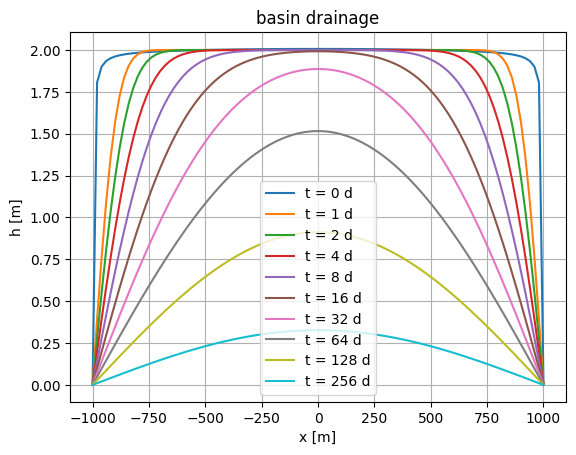

In [70]:
b = 1000 # m
kD = 650 # m2/d
S = 0.2 # [-]
A = 2 # m
times = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

ax = newfig('basin drainage', 'x [m]', 'h [m]')

x, hds = hbasin(b=b, times=times, kD=kD, S=S, A=A, jmax=100)

for t, h in zip(times, hds):
    ax.plot(x, h, label='t = {:.4g} d'.format(t))
ax.legend()

# print(h)

## Pumping experiment

1. The drawdown over time caused by the pumping over a long period for a set of piezometer (distances) from the well.

Show the drawdown development for the piezometers over time on logarithmic time scales since the start of the pumping test.
Try to simulate them with both Theis and Hantush. You can first analyse the drawdown development using methods on half-log paper or double log paper. Then simulate the measurements to the extent possible.
Then explain the results.

In [30]:
def find_primes(n):
    """Return all prime numbers from 2 through n (Sieve of Eratosthenes)."""    
    primes = set(np.arange(2, n))
    for i in range(2, n):        
        primes = primes.difference(np.arange(2 * i, n, i))        
    return np.array(sorted(primes))

find_primes(175)

array([  2,   3,   5,   7,  11,  13,  17,  19,  23,  29,  31,  37,  41,
        43,  47,  53,  59,  61,  67,  71,  73,  79,  83,  89,  97, 101,
       103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167,
       173])

In [37]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(6, 6)):
    """Return ax of new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize: fig.set_size_inches = figsize
    ax.grid(True)
    return ax

# Pumping experiment

In [15]:
def Wh(u, rho):
    """Return Hantush well function values.
    
    >>>Wh(0.004, 0.03)
    4.894104204671381
    >>>Wh(0.08, 0.06)
    2.0184074022446836
    """
    def kernel(y, rho):
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho):
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1)
    return wh(u, rho)

def W(u):
    """Return Theis well function values."""
    return exp1(u)

In [33]:
# Generate data for the piezometeres
Q = 789 # m3/d
kD = 650 # m2/d
c = 450 # d
r = find_primes(175); r = r[r > 10]
for i in range(0,6):
    print(primes[i::6])
     

[  2  17  41  67  97 127 157]
[  3  19  43  71 101 131 163]
[  5  23  47  73 103 137 167]
[  7  29  53  79 107 139 173]
[ 11  31  59  83 109 149]
[ 13  37  61  89 113 151]


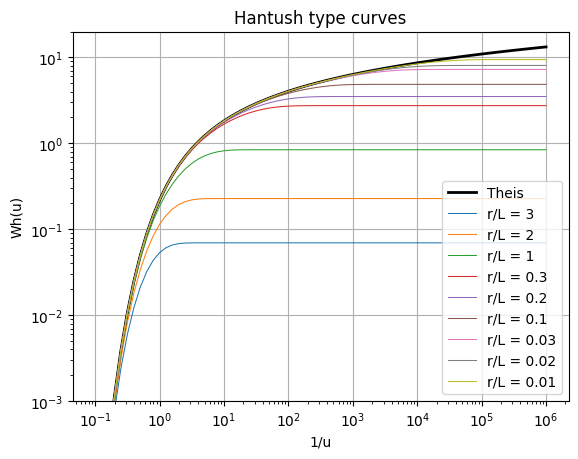

In [48]:
ax = newfig('Hantush type curves', '1/u', 'Wh(u)', xscale='log', yscale='log',
            ylim=(1e-3, 20), figsize=(8, 8))

u = np.logspace(-6, 1, 71)
ax.plot(1 / u, W(u), 'k', lw=2, label='Theis')

for rho in [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]:
    plt.plot(1 / u, Wh(u, rho), lw=0.75, label='r/L = {:.3g}'.format(rho))
ax.legend(loc='lower right')

In [ ]:
# Now we need the values from a numerical model